In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import entropy 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('vgsales.csv')
# Make sure Year is treated as a categorical variable for better visualization
df['Year'] = df['Year'].astype('Int64')  # Handle potential NaN values
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


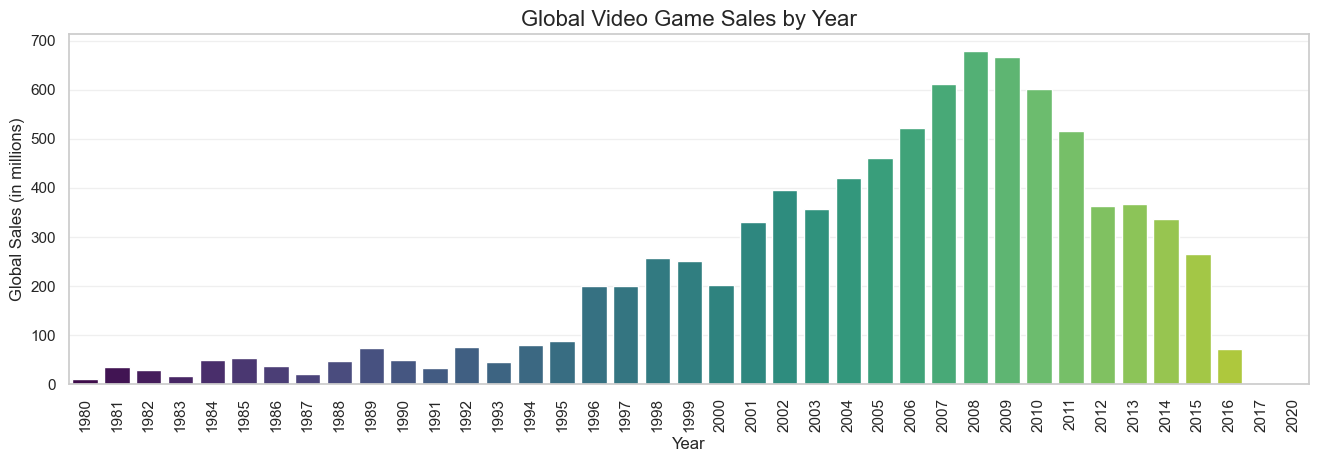

In [57]:
# 1. Create a visualization of Global_Sales over Year

plt.figure(figsize=(16, 10))

# First subplot - Global Sales by Year
plt.subplot(2, 1, 1)
yearly_sales = df.groupby('Year')['Global_Sales'].sum().reset_index()
sns.barplot(x='Year', y='Global_Sales', data=yearly_sales, palette='viridis', hue='Year', legend=False)
plt.title('Global Video Game Sales by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Global Sales (in millions)', fontsize=12)
plt.xticks(rotation=90)  # Rotate year labels for better readability
plt.grid(axis='y', alpha=0.3)

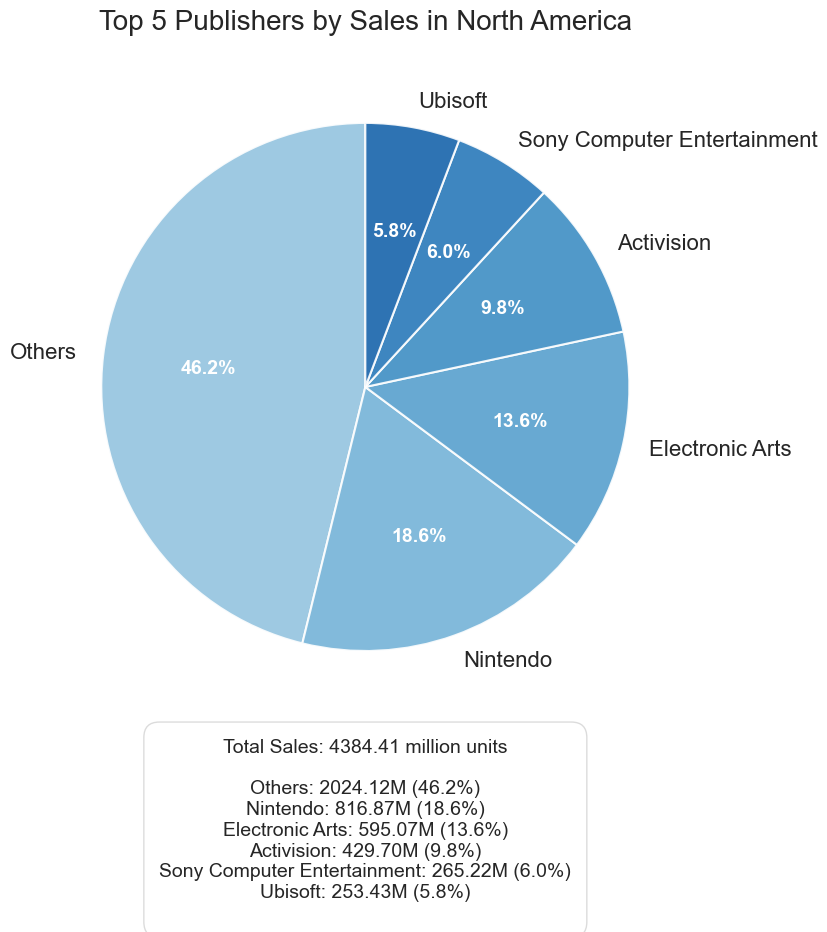

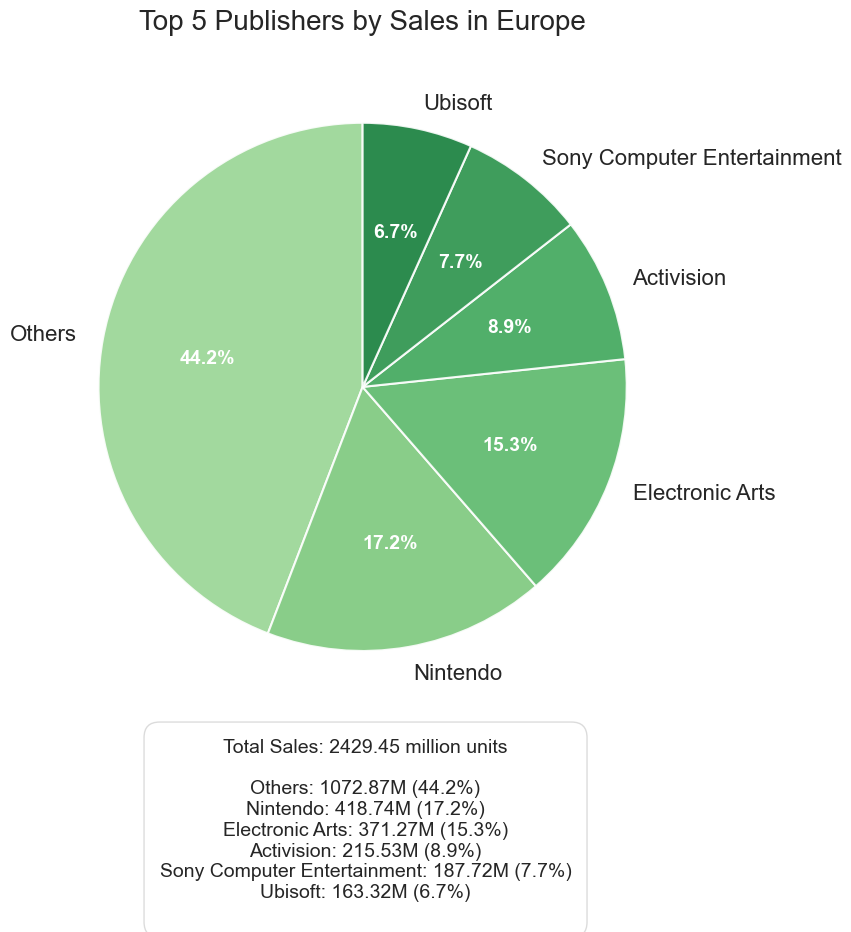

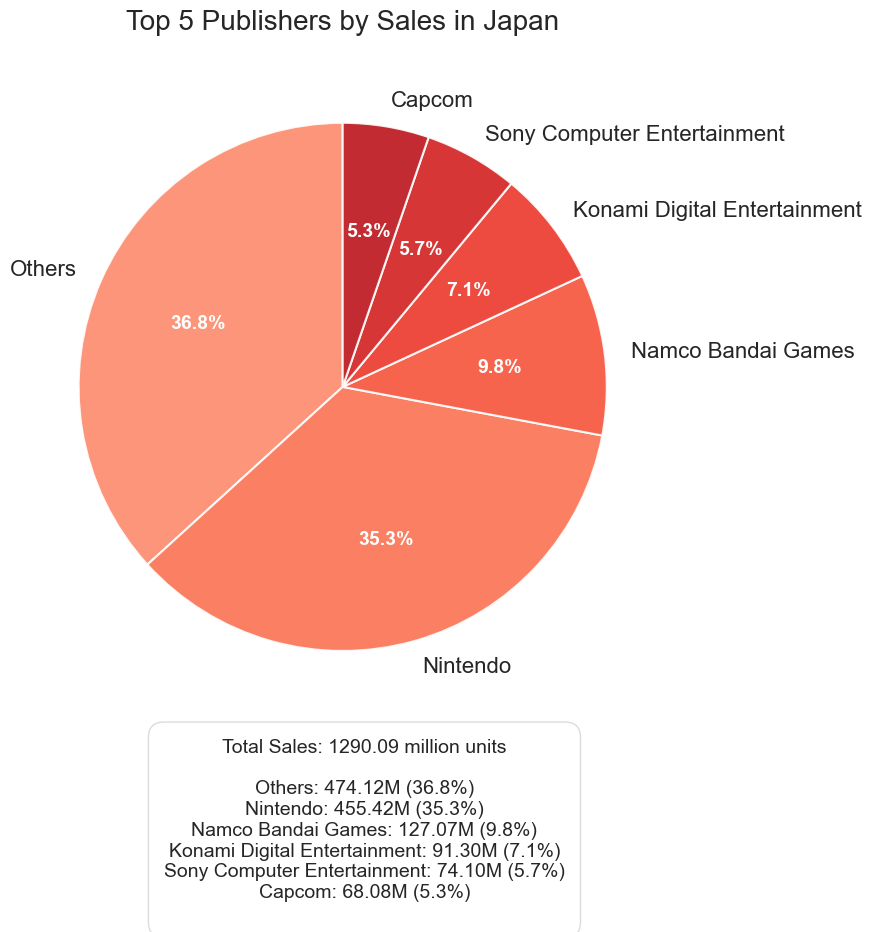

In [58]:
# 2. Create visualizations of Publisher's Regional Sales (Top 5)

# Set a clean, modern style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})

# Aggregate sales by publisher using df
publisher_sales = df.groupby('Publisher')[['NA_Sales', 'EU_Sales', 'JP_Sales']].sum()

# Define regions and their corresponding colors
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales']
titles = ['North America', 'Europe', 'Japan']
color_maps = ['Blues', 'Greens', 'Reds']

# Create individual pie charts for better readability
for region, title, cmap in zip(regions, titles, color_maps):
    # Get top 5 publishers for this specific region
    top_publishers = publisher_sales[region].nlargest(5).index
    other_publishers = publisher_sales.loc[~publisher_sales.index.isin(top_publishers)]
    
    # Create a new DataFrame with top publishers and "Others" category for this region
    plot_data = pd.concat([
        publisher_sales.loc[top_publishers, [region]],
        pd.DataFrame({region: [other_publishers[region].sum()]}, index=['Others'])
    ])
    
    # Sort data by sales value (descending)
    plot_data = plot_data.sort_values(by=region, ascending=False)
    
    # Create figure with more space at the bottom for annotations
    plt.figure(figsize=(12, 10))
    
    # Create a subplot with adjusted position to leave space at the bottom
    ax = plt.subplot(111)
    
    # Adjust the subplot position to leave more space at the bottom
    plt.subplots_adjust(bottom=0.25)
    
    # Get color map with appropriate number of colors
    colors = plt.colormaps[cmap](np.linspace(0.4, 0.8, len(plot_data)))
    
    # Create pie chart
    wedges, texts, autotexts = ax.pie(
        plot_data[region], 
        labels=plot_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1.5, 'alpha': 0.9},
        textprops={'fontsize': 16}
    )
    
    # Style the percentages
    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Add title and sales information
    ax.set_title(f'Top 5 Publishers by Sales in {title}', fontsize=20, pad=20)
    
    # Add total sales and actual values as annotation
    total_sales = plot_data[region].sum()
    annotation_text = f"Total Sales: {total_sales:.2f} million units\n\n"
    
    for idx, row in plot_data.iterrows():
        sales_value = row[region]
        percentage = (sales_value / total_sales) * 100
        annotation_text += f"{idx}: {sales_value:.2f}M ({percentage:.1f}%)\n"
    
    # Add the annotation box with more space between it and the chart
    plt.figtext(0.5, 0.02, annotation_text, ha='center', fontsize=14, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.8', 
                          edgecolor='lightgray'))
    
    # Adjust layout but respect bottom space
    plt.tight_layout(rect=[0, 0.2, 1, 0.95])  
    plt.show()

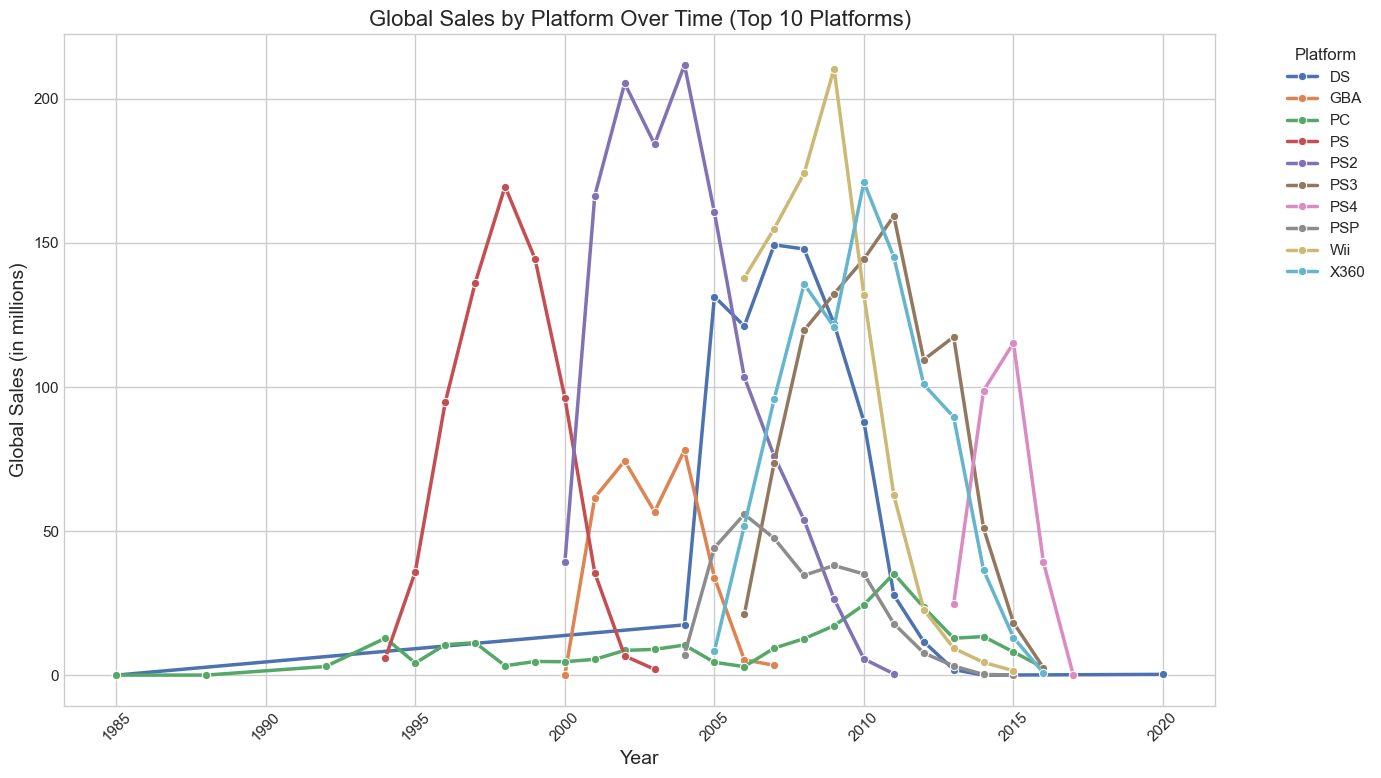

In [59]:
# 3. Create a visualization for Global_Sales by Platform (Top 10)

# Set the style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')

# Figure for Platform sales over time
plt.figure(figsize=(14, 8))

# Group by Platform and Year, then sum the Global_Sales
platform_sales_by_year = df.groupby(['Platform', 'Year'])['Global_Sales'].sum().reset_index()

# Get top 10 platforms by total sales for better readability
top_platforms = df.groupby('Platform')['Global_Sales'].sum().nlargest(10).index

# Filter for only top platforms
platform_sales_filtered = platform_sales_by_year[platform_sales_by_year['Platform'].isin(top_platforms)]

# Create the line plot
sns.lineplot(data=platform_sales_filtered, x='Year', y='Global_Sales', hue='Platform', 
             linewidth=2.5, marker='o', markersize=6)

plt.title('Global Sales by Platform Over Time (Top 10 Platforms)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Global Sales (in millions)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

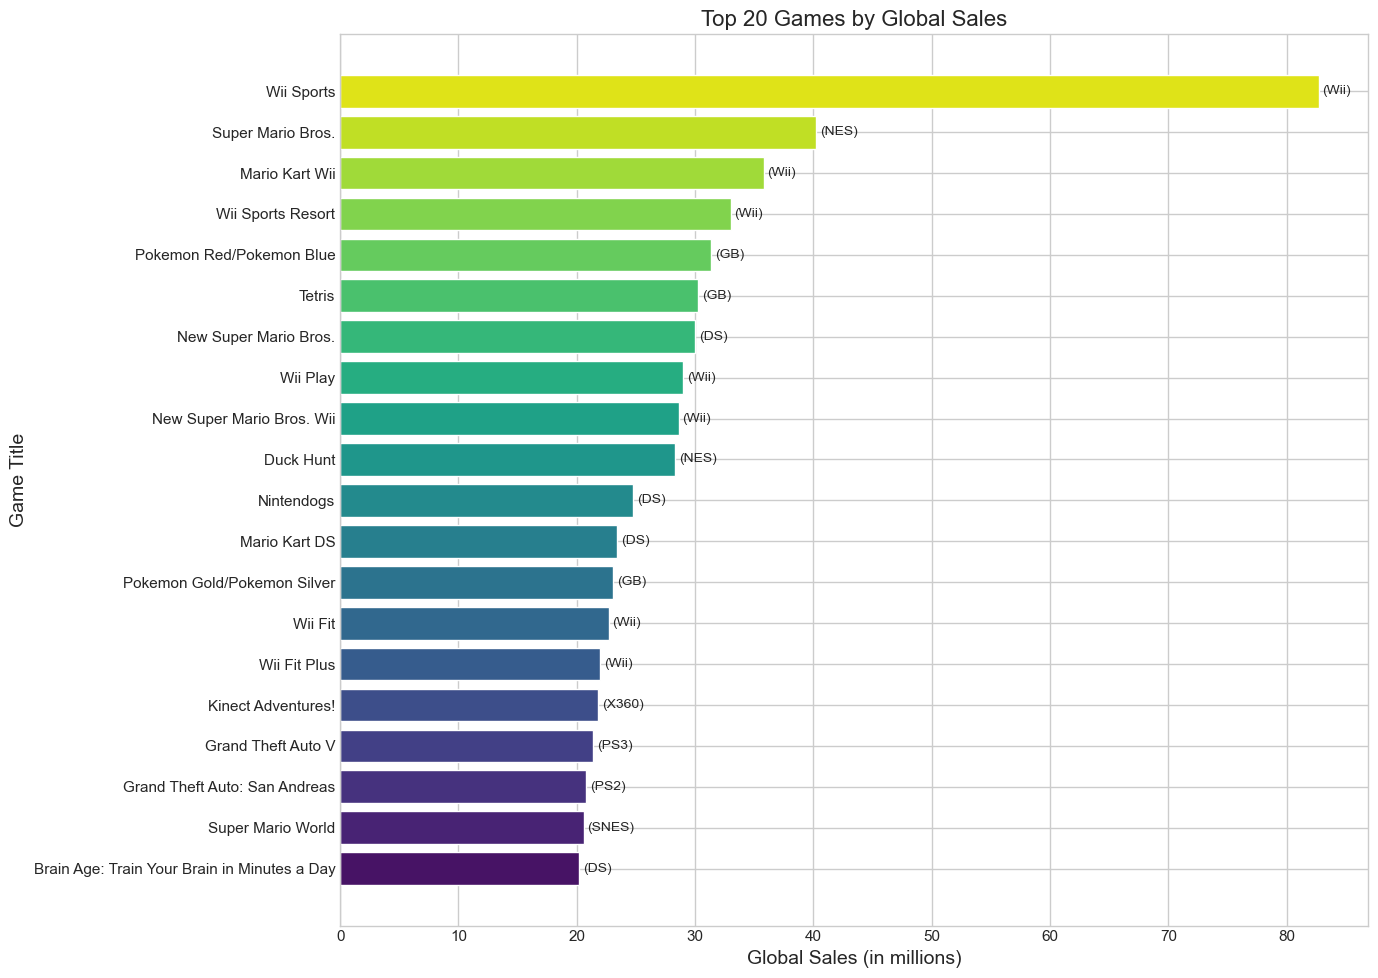

In [60]:
# 4. Create a visualization for Global Sales by Game Name (Top 20)

# Set the style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')

# Create Figure
plt.figure(figsize=(14, 10))

# Get top 20 games by global sales
top_games = df.nlargest(20, 'Global_Sales')

# Sort by sales for better visualization
top_games = top_games.sort_values('Global_Sales')

# Create horizontal bar chart
bars = plt.barh(top_games['Name'], top_games['Global_Sales'], color=sns.color_palette('viridis', 20))

# Add platform information to each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
             f"({top_games.iloc[i]['Platform']})", 
             va='center', fontsize=10)

plt.title('Top 20 Games by Global Sales', fontsize=16)
plt.xlabel('Global Sales (in millions)', fontsize=14)
plt.ylabel('Game Title', fontsize=14)
plt.tight_layout()
plt.show()